In [104]:
import pandas as pd

file = "un-general-debates-blueprint.csv.gz"

df = pd.read_csv(file)

df.sample(2)

,session,year,country,country_name,speaker,position,text
4112,53,1998,BGD,Bangladesh,Abdus Samad Azad,Minister for Foreign Affairs,"May I convey to you, Sir,\non behalf of my del..."
3228,48,1993,BFA,Burkina Faso,Mr. SANON,NaN,"Before I begin my statement, I should like to ..."


In [148]:
import chardet

with open('un-general-debates-blueprint.csv.gz', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

In [149]:
print(result)

{'encoding': None, 'confidence': 0.0, 'language': None}


In [150]:
print(df)

      session  year country     country_name                  speaker  \
1922       39  1984     MDG       Madagascar              BEMANANJARA   
1807       38  1983     SLV      El Salvador             CHAVEZ-MENA    
6882       67  2012     SDN            Sudan              Ahmed Karti   
2705       44  1989     SUR         Suriname                   SEDOC    
3589       50  1995     BLZ           Belize               Mr. Barrow   
...       ...   ...     ...              ...                      ...   
672        30  1975     TGO             Togo              Mr. HUNLEDE   
2242       41  1986     SLB  Solomon Islands                Mr. TOVUA   
3508       49  1994     MUS        Mauritius     Sir Anerood Jugnauth   
7345       70  2015     CHL            Chile  Michelle Bachelet Jeria   
2010       40  1985     CMR         Cameroon             Mr; Mboumoua   

                          position  \
1922                           NaN   
1807                           NaN   
6882  Min

In [108]:
df = df.sample(frac = 0.1)

In [109]:
df['length'] = df['text'].str.len()

df.describe().T


,count,mean,std,min,25%,50%,75%,max
session,751.0,48.822903,12.671093,25.0,38.0,50.0,59.5,70.0
year,751.0,1993.822903,12.671093,1970.0,1983.0,1995.0,2004.5,2015.0
length,751.0,17871.343542,7632.225394,4543.0,12200.5,16446.0,22321.5,63259.0


In [110]:
df[['country','speaker']].describe(include='O').T

,count,unique,top,freq
country,751,193,SYR,9
speaker,750,716,Franco Frattini,3


In [111]:
df.isna().sum()

session           0
year              0
country           0
country_name      0
speaker           1
position        320
text              0
length            0
dtype: int64

In [112]:
df['speaker'].fillna('unknown',inplace = True)

In [113]:
df.isna().sum()

session           0
year              0
country           0
country_name      0
speaker           0
position        320
text              0
length            0
dtype: int64

In [114]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George Bush           1
Mr. George W. Bush    1
Name: speaker, dtype: int64

<Axes: >

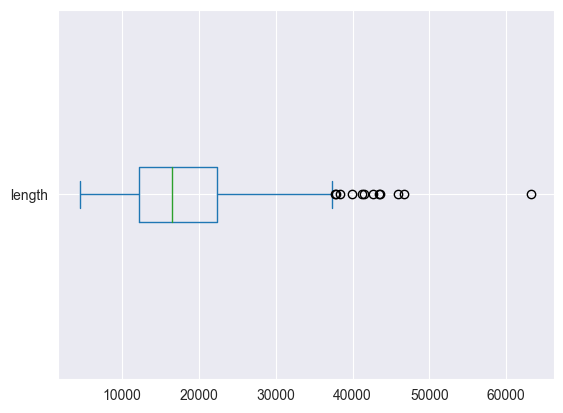

In [115]:
import matplotlib as mp
df['length'].plot(kind='box',vert=False)

<Axes: ylabel='Frequency'>

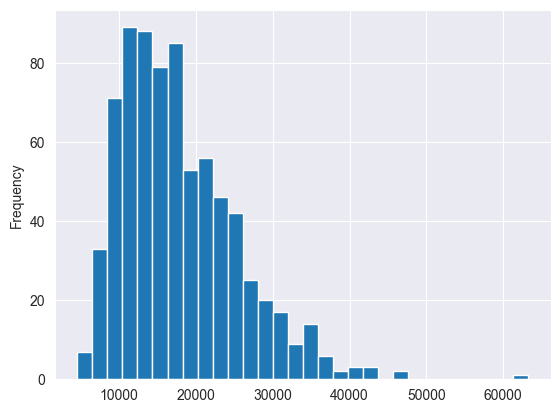

In [116]:
df['length'].plot(kind = 'hist' ,bins = 30)

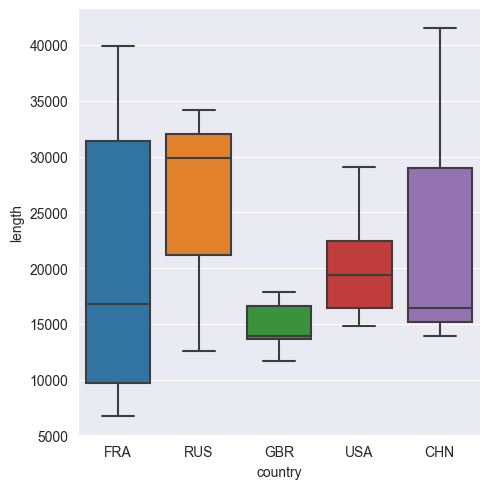

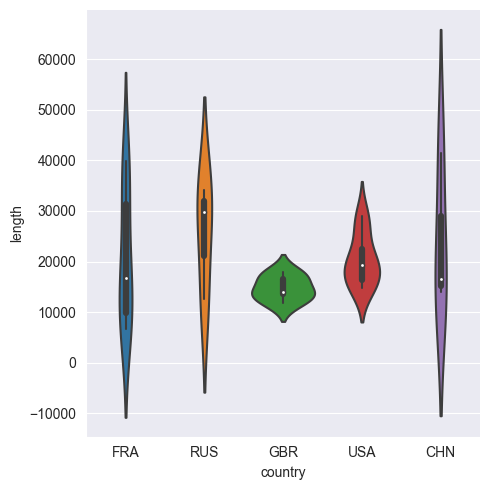

In [117]:
import seaborn as sns

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data = df[where], x='country', y='length', kind='box')
sns.catplot(data = df[where], x='country', y='length', kind='violin')

<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

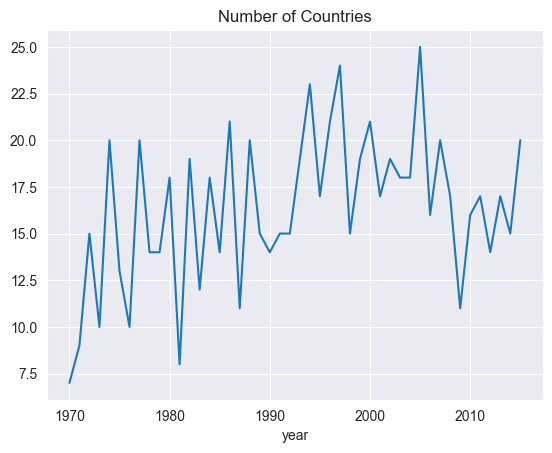

In [118]:
df.groupby('year').size().plot(title = "Number of Countries")

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

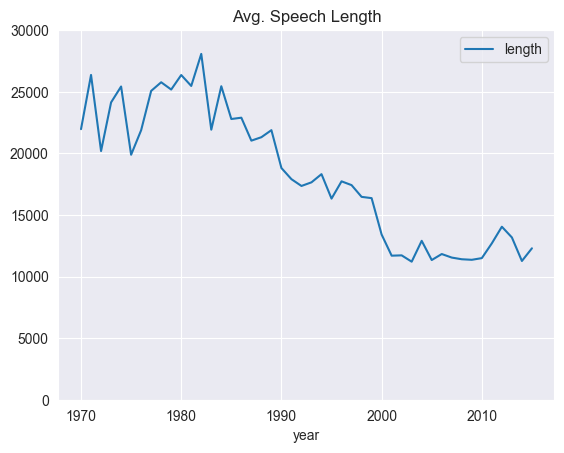

In [119]:
df.groupby('year').agg({'length':'mean'}).plot(title = "Avg. Speech Length", ylim=(0, 30000))

In [ ]:
#df['year'] = df['time'].dt.year

In [ ]:
#df['week'] = df['time'].dt.strftime('%Y/Week %W')

In [120]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*',text)

text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))


Let|s|defeat|SARS-CoV-2|together|in


In [121]:
import nltk
# nltk.download()
stopwords = set(nltk.corpus.stopwords.words('english'))


In [122]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [125]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

In [126]:
pipeline =[str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [127]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [128]:
df['num_tokens'] = df['tokens'].map(len)

In [129]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)

print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [130]:
more_tokens = tokenize("She likes dogs and cats.")

counter.update(more_tokens)

print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [131]:
counter = Counter()

df['tokens'].map(counter.update)

1922    None
1807    None
6882    None
2705    None
3589    None
        ... 
672     None
2242    None
3508    None
7345    None
2010    None
Name: tokens, Length: 751, dtype: object

In [132]:
print(counter.most_common(5))

[('nations', 12639), ('united', 12249), ('international', 11453), ('world', 8888), ('countries', 8222)]


In [133]:
def count_words(df, column='tokens', preprocess=None, min_freq=2 ):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    counter = Counter()
    df[column].map(update)

    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)


In [134]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,12639
united,12249
international,11453
world,8888
countries,8222


In [135]:
count_words(df, column='text', preprocess=lambda text: re.findall(r"\w{2,}", text))

,freq
token,
the,176187
of,114744
and,78199
to,73211
in,47373
...,...
lain,2
Mayardit,2
captives,2


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

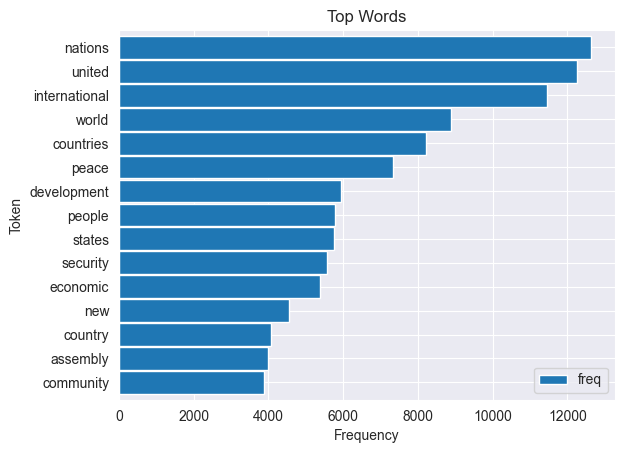

In [136]:
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

In [151]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0]

wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [138]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, background_color="black", colormap="Paired",
                   max_font_size=150, max_words= max_words)
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

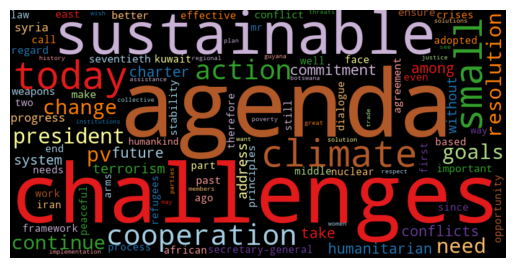

In [139]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

In [140]:
import numpy as np
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    counter = Counter()
    df[column].map(update)

    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df= idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [141]:
idf_df = compute_idf(df)

C:\Users\ybhsos\AppData\Local\Temp\ipykernel_6128\3006849578.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


In [142]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [143]:
print(freq_df)

                freq        tfidf
token                            
nations        12639  1314.489794
united         12249  1241.221122
international  11453  1206.464364
world           8888   912.501347
countries       8222  1021.665308
...              ...          ...
conservatism       2    12.056517
prognosis          2    12.056517
minimally          2    12.056517
scales             2    12.056517
arrestation        2          NaN

[17481 rows x 2 columns]


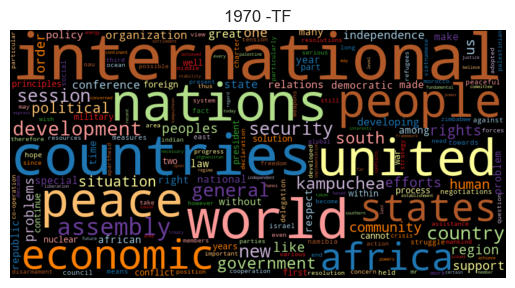

In [152]:
freq_1970 = count_words(df[df['year'] == 1980])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
wordcloud(freq_1970['freq'], title='1970 -TF', stopwords=['twenty-fifth', 'twenty-five'])
#wordcloud(freq_2015['freq'], title='2015 -TF', stopwords=['seventieth'])
#wordcloud(freq_1970['freq'], title='1970 -TF-IDF', stopwords=['twenty-fifth', 'twenty-five'])
#wordcloud(freq_2015['freq'], title='2015 -TF-IDF', stopwords=['seventieth'])





In [164]:
#from textacy import KWIC
from textacy.extract.kwic import keyword_in_context

def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(kwic(doc_series, keyword, windows=35, ignore_case = True, window_width=window, print_only= False))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples ==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)}" + \
              f"contexts for '{keyword}':"
              )
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]',' ', sample[0])+ ' ' +\
                  sample[1]+' '+\
                  re.sub(r'[\n\t]',' ', sample[2]))

In [165]:
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

TypeError: kwic() got an unexpected keyword argument 'windows'

In [166]:
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC

else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args,
                           **{kw: arg for kw, arg in kwargs.items()
                            if kw != 'print_only'})

In [167]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True,
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [ ]:
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

In [171]:
def  ngrams (tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text ="the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [174]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) if len([t for t in ngram if t in stopwords])==0]

print("bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [175]:
df['bigrams'] = df["text"].apply(prepare, pipeline=[str.lower, tokenize]) \
    .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

,freq
token,
united nations,10515
international community,2804
general assembly,2687
security council,1965
human rights,1901


C:\Users\ybhsos\AppData\Local\Temp\ipykernel_6128\3006849578.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


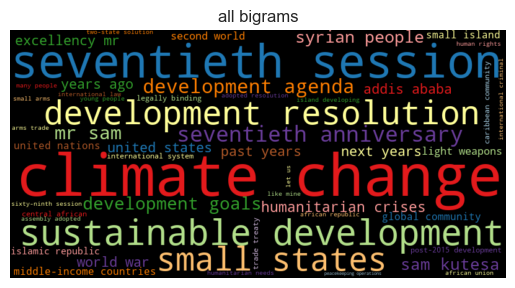

In [176]:
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015],'bigrams')

freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

wordcloud(freq_df['tfidf'], title='all bigrams', max_words = 50)


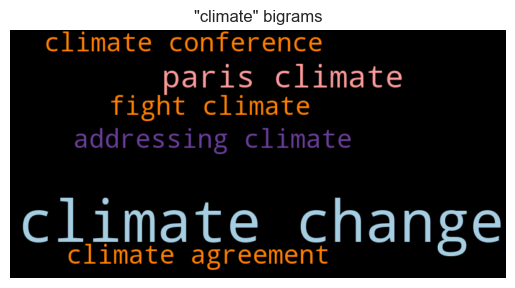

In [177]:
where = freq_df.index.str.contains('climate')

wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

In [181]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [182]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [199]:
import pandas as pd
from tqdm import tqdm
def count_keywords_by(df, by, keywords, column='tokens'):

    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)

    return freq_df.groupby(by=by).sum().sort_values(by)

In [202]:
freq_df = count_keywords_by(df, by ='year', keywords=keywords)
print (freq_df)

      nuclear  terrorism  climate  freedom
year                                      
1970       11          0        6        8
1971       48          1        0        7
1972       13         36       11       35
1973       29         18       13       20
1974      107          3       10       43
1975       22          5        3       16
1976       28          5        3       24
1977      121          9       15       57
1978       54         11        2       25
1979       28          2        4       33
1980       67         16       14       42
1981       43         20        4       14
1982       80         10       14       39
1983       57          9        5       22
1984       72          7       20       32
1985       51         31       11       26
1986      130         67        7       41
1987       42          3        8       27
1988       63         16       36       51
1989       56         24       29       33
1990       12          5       15       20
1991       

<Axes: xlabel='year'>

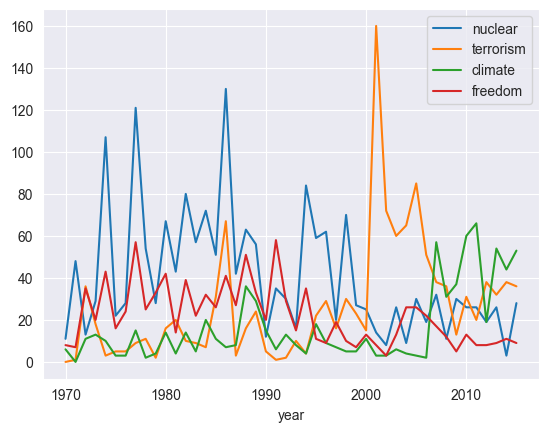

In [201]:
freq_df.plot(kind='line')

<Axes: xlabel='year'>

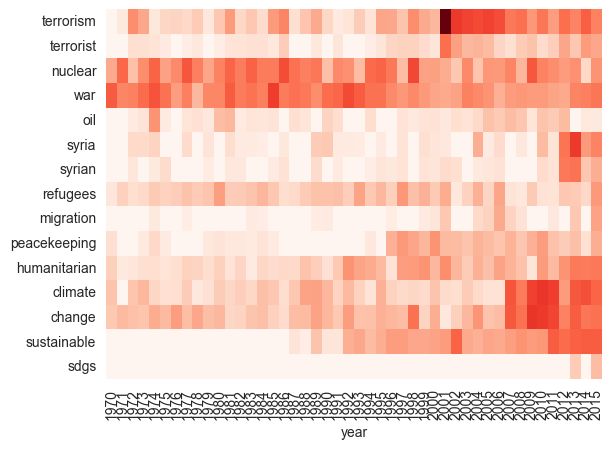

In [205]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping',
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']
freq_df = count_keywords_by(df, by='year', keywords=keywords)

freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)

freq_df = freq_df.apply(np.sqrt)

sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")


